In [1]:
# 1. Setup and Load Data

import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Paths
cwd = Path.cwd()
BASE_DIR = cwd.parent
DATA_DIR = BASE_DIR / 'data' / 'processed'

# Candidate Files
CANDIDATES = [
    'analysis_base_with_full_interpolation.csv',  # Interpolated, Median-Filled
    'merged_panel_1960_2018.csv',                 # Non-Interpolated, No Median-Filling
]

def load_panel_df():
    for name in CANDIDATES:
        f = DATA_DIR / name
        if f.exists():
            if f.suffix == '.csv':
                return pd.read_csv(f)
            elif f.suffix == '.parquet':
                return pd.read_parquet(f)
    raise FileNotFoundError(f'None of the Candidates Found in {DATA_DIR}: {CANDIDATES}')

df = load_panel_df()

# Sanity Checks
required_cols = {'Country', 'Year', 'fertility', 'flfp', 'urban_pop', 'migration'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing Required Columns in Dataset: {missing}')

# Ensure Dtypes
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
num_cols = ['fertility', 'flfp', 'urban_pop', 'migration']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop Rows with no Country or Year
df = df.dropna(subset=['Country', 'Year']).copy()
df.shape, df.head(3)

((12449, 6),
        Country  Year  fertility  migration  urban_pop  flfp
 0  Afghanistan  1960      7.282     2606.0      8.401  6.83
 1  Afghanistan  1961      7.284     6109.0      8.684  6.83
 2  Afghanistan  1962      7.292     7016.0      8.976  6.83)

In [2]:
# 2. Helpers for Correlation Scopes

VALUE_COLS = ['fertility', 'flfp', 'urban_pop', 'migration']

def corr_pooled(df):
    """Simple Pearson Correlation on All Rows (Ignores Panel Structure)."""
    return df[VALUE_COLS].corr()

def corr_within(df):
    """Within-Country Correlation: Demean Each Value by Its Country Mean, Then Correlate."""
    g = df.groupby('Country')[VALUE_COLS]
    demeaned = df.copy()
    demeaned[VALUE_COLS] = g.transform(lambda x: x - x.mean())
    return demeaned[VALUE_COLS].corr()

def corr_between(df):
    """Between-Country Correlation: Correlate Country-Level Means."""
    means = df.groupby('Country', as_index=False)[VALUE_COLS].mean()
    return means[VALUE_COLS].corr()

def plot_heatmap(mat, title):
    """Heatmap Using matplotlib.imshow with Value Annotations."""
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    data = mat.values
    im = ax.imshow(data, vmin=-1, vmax=1)
    ax.set_xticks(range(len(mat.columns)))
    ax.set_xticklabels(mat.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(mat.index)))
    ax.set_yticklabels(mat.index)
    ax.set_title(title)
    # Add Colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Add Annotations
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

def scatter_with_fit(x, y, xlabel, ylabel, title, alpha=0.45, sample=5000):
    """Scatter + Simple OLS Fit Line Using numpy.polyfit. One Figure per Chart."""
    # Downsample if Very Large
    n = len(x)
    if n > sample:
        idx = np.random.RandomState(42).choice(n, size=sample, replace=False)
        x = x.iloc[idx]
        y = y.iloc[idx]
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.scatter(x, y, alpha=alpha)
    # Fit Line
    mask = (~pd.isna(x)) & (~pd.isna(y))
    if mask.sum() >= 2:
        b1, b0 = np.polyfit(x[mask], y[mask], 1)
        xx = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 100)
        yy = b1 * xx + b0
        ax.plot(xx, yy, linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

,fertility,flfp,urban_pop,migration
fertility,1.000,-0.246,-0.613,-0.044
flfp,-0.246,1.000,-0.026,0.032
urban_pop,-0.613,-0.026,1.000,0.120
migration,-0.044,0.032,0.120,1.000


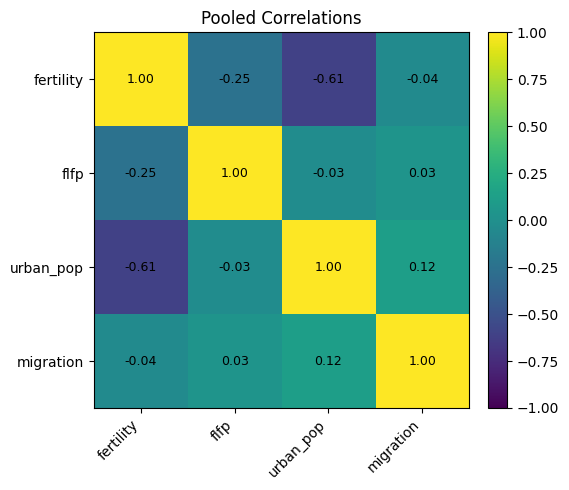

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\corr_pooled.png


,fertility,flfp,urban_pop,migration
fertility,1.000,-0.481,-0.686,0.052
flfp,-0.481,1.000,0.399,0.011
urban_pop,-0.686,0.399,1.000,-0.011
migration,0.052,0.011,-0.011,1.000


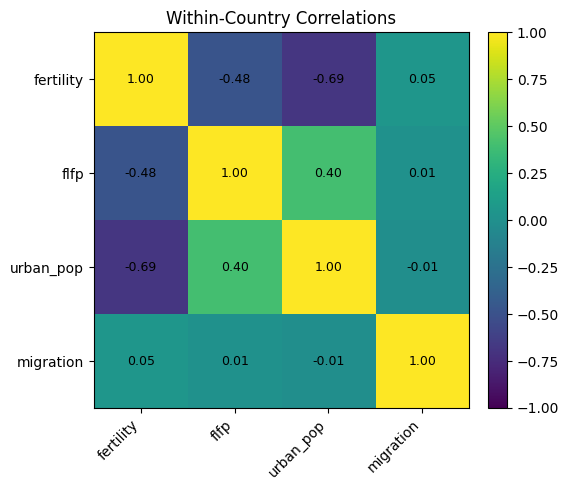

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\corr_within.png


,fertility,flfp,urban_pop,migration
fertility,1.000,-0.131,-0.622,-0.186
flfp,-0.131,1.000,-0.136,0.072
urban_pop,-0.622,-0.136,1.000,0.286
migration,-0.186,0.072,0.286,1.000


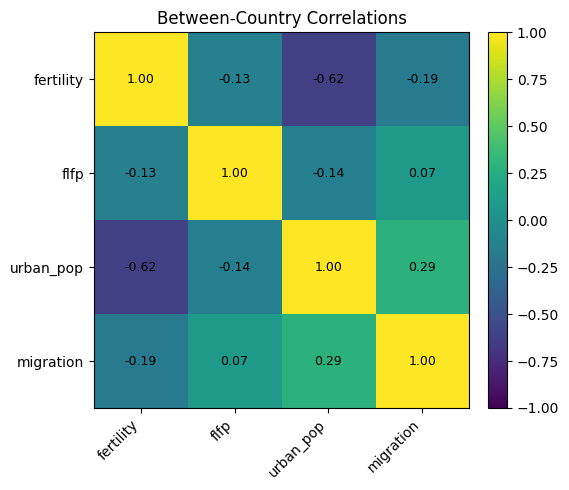

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\corr_between.png


In [3]:
# 3. Correlation Heatmaps

OUT_DIR = DATA_DIR / 'visuals'
OUT_DIR.mkdir(parents=True, exist_ok=True)

def plot_and_save_heatmap(mat, title, filename):
    """Plot Heatmap and Save Figure as PNG."""
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    data = mat.values
    im = ax.imshow(data, vmin=-1, vmax=1)
    ax.set_xticks(range(len(mat.columns)))
    ax.set_xticklabels(mat.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(mat.index)))
    ax.set_yticklabels(mat.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Add Annotations
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)
    plt.tight_layout()
    
    # Save as PNG
    out_path = OUT_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")

# Compute Correlations
corr_p = corr_pooled(df)
corr_w = corr_within(df)
corr_b = corr_between(df)

# Plot + Save
display(corr_p.round(3))
plot_and_save_heatmap(corr_p, 'Pooled Correlations', 'corr_pooled.png')

display(corr_w.round(3))
plot_and_save_heatmap(corr_w, 'Within-Country Correlations', 'corr_within.png')

display(corr_b.round(3))
plot_and_save_heatmap(corr_b, 'Between-Country Correlations', 'corr_between.png')

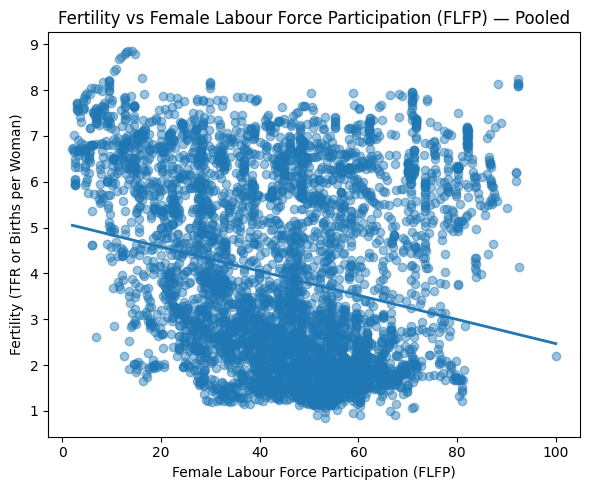

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_flfp_pooled.png


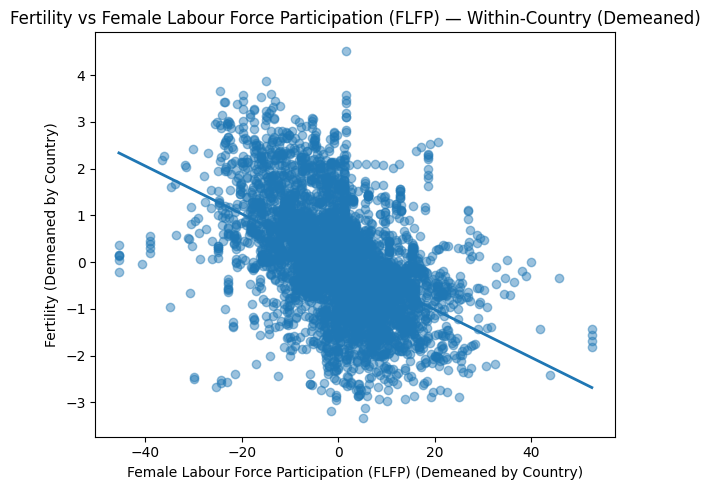

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_flfp_within.png


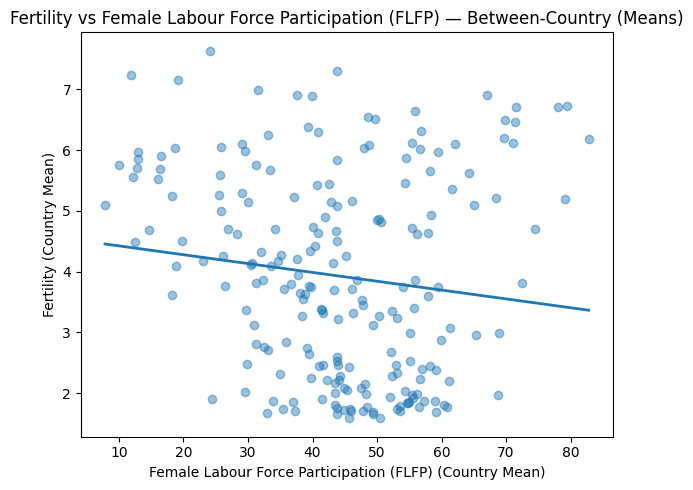

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_flfp_between.png


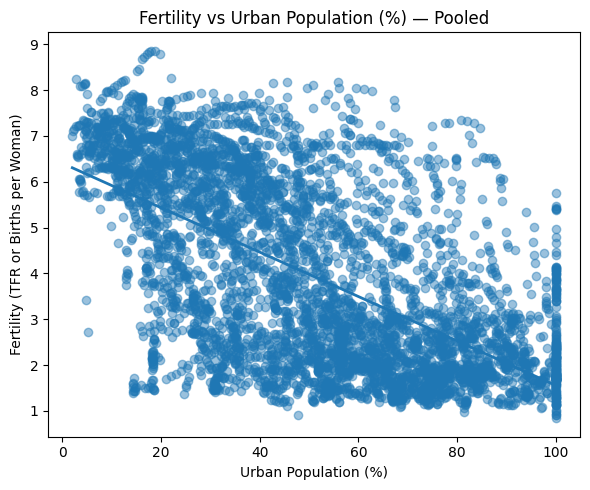

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_urban_pop_pooled.png


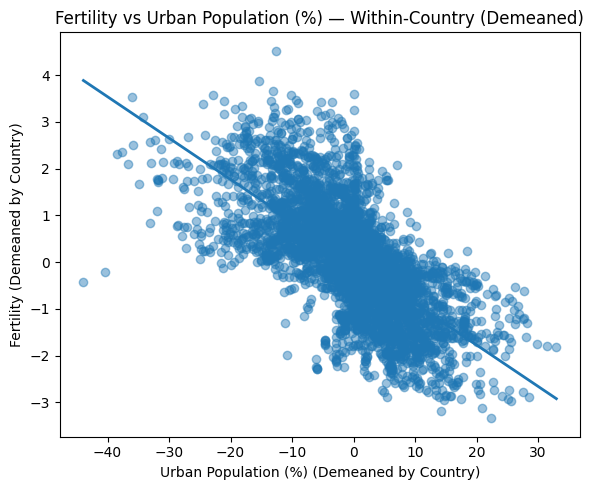

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_urban_pop_within.png


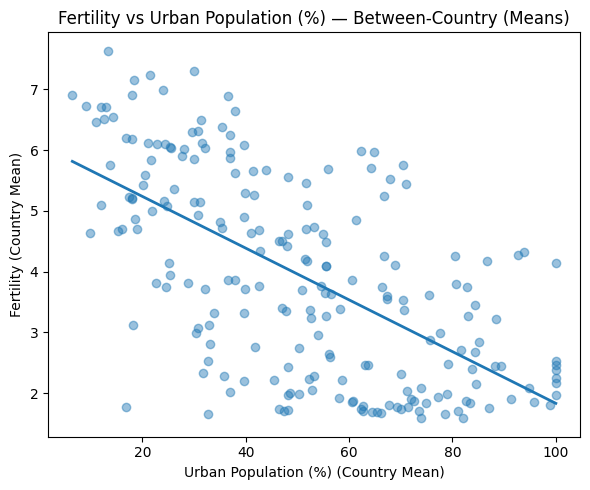

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_urban_pop_between.png


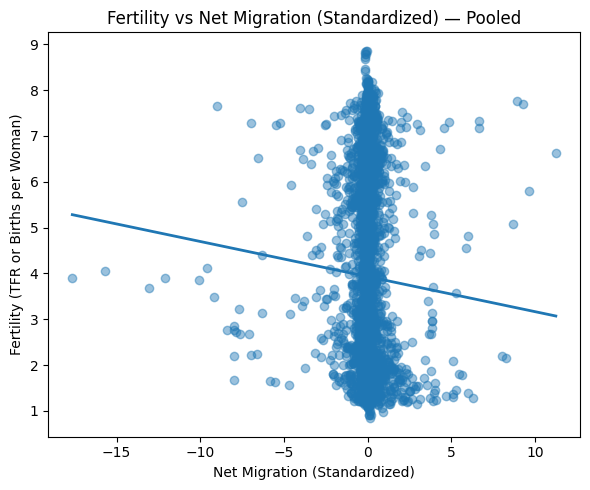

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_migration_z_pooled.png


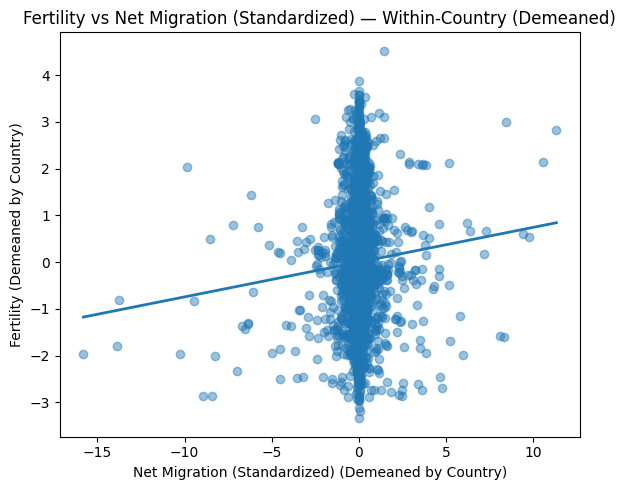

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_migration_z_within.png


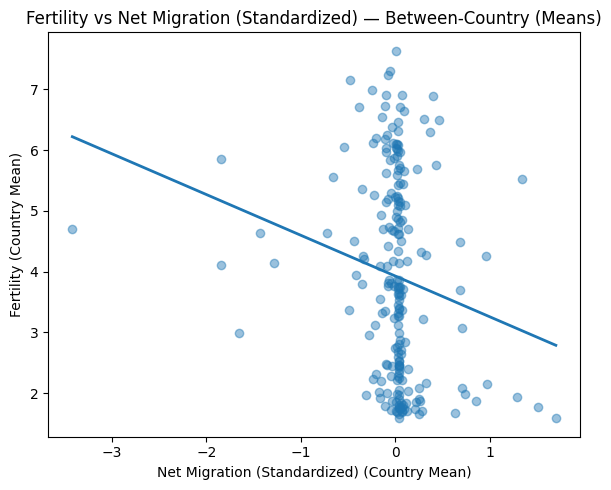

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_migration_z_between.png


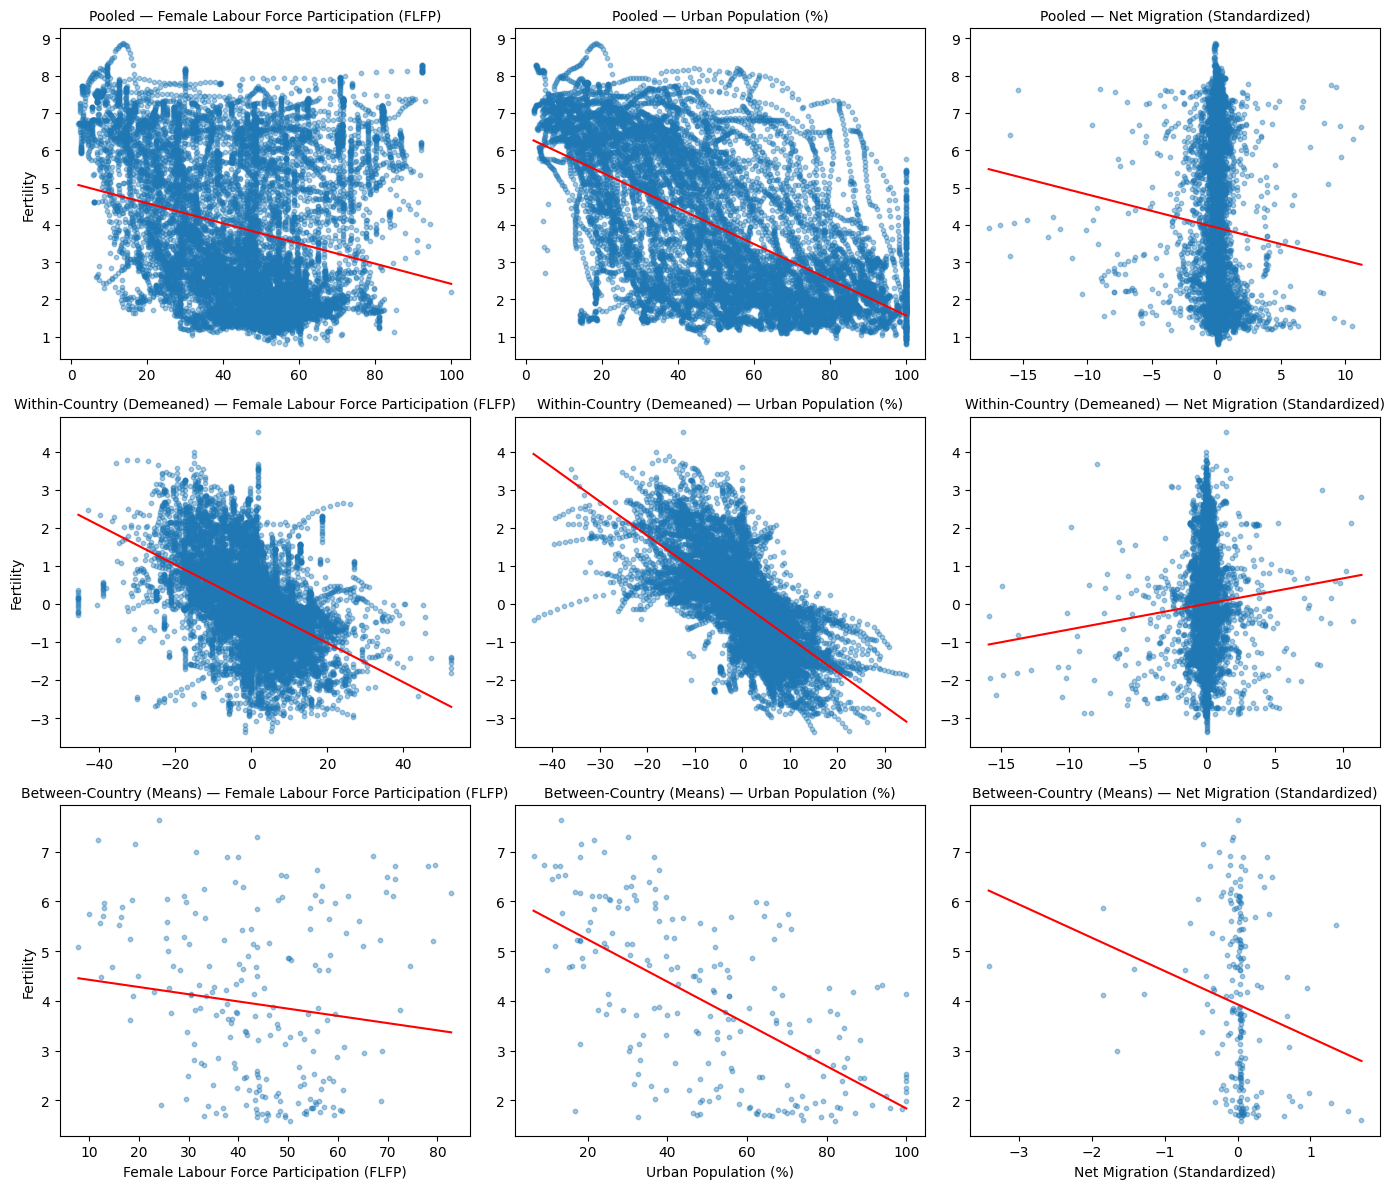

Saved Combined Figure: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\visuals\scatter_combined_9grid.png


In [4]:
# 4. Scatter Plots (Pooled / Within / Between) (Migration Standardized + Save)

OUT_DIR = DATA_DIR / 'visuals'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Scale Migration with z-score (Only for Visualization)
df['migration_z'] = (df['migration'] - df['migration'].mean()) / df['migration'].std(ddof=0)

pairs = [
    ('flfp', 'Female Labour Force Participation (FLFP)'),
    ('urban_pop', 'Urban Population (%)'),
    ('migration_z', 'Net Migration (Standardized)'),
]

# Within-Country (Demeaned) and Between-Country (Means) Sets
value_cols = ['fertility', 'flfp', 'urban_pop', 'migration_z']

g = df.groupby('Country')[value_cols]
df_within = df.copy()
df_within[value_cols] = g.transform(lambda s: s - s.mean())

df_between = df.groupby('Country', as_index=False)[value_cols].mean()

def scatter_with_fit_and_save(x, y, xlabel, ylabel, title, filename, alpha=0.45, sample=5000):
    """Scatter Plot with OLS Fit Line + Save as PNG."""
    n = len(x)
    if n > sample:
        idx = np.random.RandomState(42).choice(n, size=sample, replace=False)
        x = x.iloc[idx]
        y = y.iloc[idx]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.scatter(x, y, alpha=alpha)
    mask = (~pd.isna(x)) & (~pd.isna(y))
    if mask.sum() >= 2:
        b1, b0 = np.polyfit(x[mask], y[mask], 1)
        xx = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 100)
        yy = b1 * xx + b0
        ax.plot(xx, yy, linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    
    # Save Figure
    out_path = OUT_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")

# Scatter Plots (Each Graph is a Separate Figure, Simple OLS Fit Line)
for col, label in pairs:
    # Pooled
    scatter_with_fit_and_save(
        df[col], df['fertility'],
        xlabel=label,
        ylabel='Fertility (TFR or Births per Woman)',
        title=f'Fertility vs {label} — Pooled',
        filename=f'scatter_{col}_pooled.png'
    )

    # Within-Country (Demeaned)
    scatter_with_fit_and_save(
        df_within[col], df_within['fertility'],
        xlabel=f'{label} (Demeaned by Country)',
        ylabel='Fertility (Demeaned by Country)',
        title=f'Fertility vs {label} — Within-Country (Demeaned)',
        filename=f'scatter_{col}_within.png'
    )

    # Between-Country (Means)
    scatter_with_fit_and_save(
        df_between[col], df_between['fertility'],
        xlabel=f'{label} (Country Mean)',
        ylabel='Fertility (Country Mean)',
        title=f'Fertility vs {label} — Between-Country (Means)',
        filename=f'scatter_{col}_between.png'
    )

#Combine All 9 Scatter Plots into One Grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(14, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

scopes = [
    ("Pooled", df),
    ("Within-Country (Demeaned)", df_within),
    ("Between-Country (Means)", df_between)
]

for i, (scope_name, data) in enumerate(scopes):
    for j, (col, label) in enumerate(pairs):
        ax = axes[i, j]
        x = data[col]
        y = data['fertility']
        mask = (~pd.isna(x)) & (~pd.isna(y))
        ax.scatter(x[mask], y[mask], alpha=0.4, s=10)

        # Fit Line
        if mask.sum() >= 2:
            b1, b0 = np.polyfit(x[mask], y[mask], 1)
            xx = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 100)
            yy = b1 * xx + b0
            ax.plot(xx, yy, color='red', linewidth=1.5)

        ax.set_xlabel(label if i == 2 else "")
        ax.set_ylabel("Fertility" if j == 0 else "")
        ax.set_title(f"{scope_name} — {label}", fontsize=10)

plt.tight_layout()

# Save Combined Figure
combined_path = OUT_DIR / "scatter_combined_9grid.png"
fig.savefig(combined_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved Combined Figure: {combined_path}")

In [1]:
# 5. Hexbin Plots for Fertility vs Migration

OUT_DIR = DATA_DIR / 'visuals'
OUT_DIR.mkdir(parents=True, exist_ok=True)

def hexbin_plot_and_save(x, y, xlabel, ylabel, title, filename, gridsize=50):
    """Hexbin Scatter (Density) + Save Figure."""
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap='viridis', mincnt=1)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Data Density')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()

    out_path = OUT_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")

# Draw in Three Scopes for Migration (Using z-score)
for scope_name, data in {
    "Pooled": df,
    "Within-Country (Demeaned)": df_within,
    "Between-Country (Means)": df_between,
}.items():
    x = data['migration_z']
    y = data['fertility']
    safe_scope = scope_name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
    hexbin_plot_and_save(
        x, y,
        xlabel='Net Migration (Standardized)',
        ylabel='Fertility (TFR or Births per Woman)',
        title=f'Fertility vs Migration — {scope_name}',
        filename=f'hexbin_migration_{safe_scope}.png'
    )

NameError: name 'DATA_DIR' is not defined

In [2]:
import pandas as pd

df = pd.read_csv("dosyanin_yolu.csv")

from sklearn.model_selection import train_test_split

X = df.drop("birth_rate", axis=1)
y = df["birth_rate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train boyut:", len(X_train))
print("Test boyut:", len(X_test))

print("Train ülke sayısı:", X_train["country"].nunique())
print("Test ülke sayısı:", X_test["country"].nunique())


FileNotFoundError: [Errno 2] No such file or directory: 'dosyanin_yolu.csv'